In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

RESULTS_FILENAME = "good_results.hdf5"

In [267]:
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def decoding_fix_axes(fig_width=10, fig_height=5, wpad_edge=0, wpad_mid=.1, hpad_edge=0, hpad_mid=.1):
    fig = plt.figure(figsize=(fig_width, fig_height))
    sq_width = (1 - 2*wpad_edge - 2*wpad_mid)/3
    sq_height = sq_width * fig_width/fig_height
    
    #top row
    ax1 = fig.add_axes((wpad_edge, hpad_edge + sq_height + hpad_mid, sq_width, sq_height))
    ax2 = fig.add_axes((wpad_edge + sq_width + wpad_mid, hpad_edge + sq_height + hpad_mid, sq_width, sq_height))
    ax3 = fig.add_axes((wpad_edge + 2*sq_width + 2*wpad_mid, hpad_edge + sq_height + hpad_mid, sq_width, sq_height))
    
    #bottom row
    ax4 = fig.add_axes((wpad_edge, hpad_edge, sq_width, sq_height))
    ax5 = fig.add_axes((wpad_edge + sq_width + wpad_mid, hpad_edge, sq_width, sq_height))
    ax6 = fig.add_axes((wpad_edge + 2*sq_width + 2*wpad_mid, hpad_edge, sq_width, sq_height))
    
    axes = (ax1, ax2, ax3, ax4, ax5, ax6)
    return axes

from matplotlib.cm import plasma
def scatter_r2_vals(r2_vals, T_pi_idx, dim_vals, offset_vals, legend=True, ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(5, 5))
           
    #calculate means across CV folds
    vals_mean = r2_vals.mean(axis=0)
    dca_mean = vals_mean[:, :, T_pi_idx + 2]
    pca_mean = vals_mean[:, :, 0]
    
    #determine window bounds
    min_val = np.min(np.concatenate(( dca_mean, pca_mean )))
    max_val = np.max(np.concatenate(( dca_mean, pca_mean )))
    val_range = max_val - min_val
    min_val -= .1 * val_range
    max_val += .1 * val_range
    ax.set_xlim([min_val, max_val])
    ax.set_ylim([min_val, max_val])
    
    #plot the diagonal line
    t = np.linspace(min_val, max_val, 100)
    ax.plot(t, t, c="black")
    
    #make scatter
    markers = ['+', 'x', 'v', 's', 'p']
    colors = plasma(np.linspace(0, .8, len(dim_vals)))
    for dim_idx in range(len(dim_vals)):
        for offset_idx in range(len(offset_vals)):
            x, y = pca_mean[dim_idx, offset_idx], dca_mean[dim_idx, offset_idx]
            ax.scatter(x, y, c=[colors[dim_idx]], marker=markers[offset_idx], s=70)
            
    #make legend
    if legend:
        for dim_idx in range(len(dim_vals)):
            ax.scatter(-1, -1, c=[colors[dim_idx]], marker="o", label="dim: "+str(dim_vals[dim_idx]), s=70)
        for offset_idx in range(len(offset_vals)):
            ax.scatter(-1, -1, c="black", marker=markers[offset_idx], label="lag: "+str(offset_vals[offset_idx]), s=70)
        ax.legend(frameon=True, ncol=2, fontsize=8, loc="lower right")
    
    #add labels/titles
    ax.set_xlabel("PCA $R^2$", fontsize=14, labelpad=0)
    ax.set_ylabel("DCA $R^2$", fontsize=14)
    
def plot_pi_vs_T(r2_vals, T_pi_vals, dim_vals, ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(5, 5))
        
    vals_mean = r2_vals.mean(axis=0)
    offset_idx = 0
    colors = plasma(np.linspace(0, .8, len(dim_vals)))
    
    #determine window bounds
    min_val = np.min(vals_mean[:, offset_idx, 1:])
    max_val = np.max(vals_mean[:, offset_idx, 1:])
    print(min_val, max_val)
    val_range = max_val - min_val
    min_val -= .1 * val_range
    max_val += .1 * val_range
    ax.set_xlim([min_val, max_val])
    ax.set_ylim([min_val, max_val])
    
    #plot the diagonal line
    t = np.linspace(min_val, max_val, 100)
    ax.plot(t, t, c="black")
    
    for dim_idx in range(len(dim_vals)):
        sfa_val = vals_mean[dim_idx, offset_idx, 1]
        for T_pi_idx in range(len(T_pi_vals)):
            ax.scatter(sfa_val, vals_mean[dim_idx, offset_idx, T_pi_idx + 2], color=colors[dim_idx])
    #ax.axhline(0)
    
    #add labels/titles
    ax.set_xlabel("PCA $R^2$", fontsize=14, labelpad=0)
    ax.set_ylabel("DCA $R^2$", fontsize=14)

    


['weather', 'm1', 'hc']
0.7907118 0.98870647
0.012295089 0.48162478
0.04781515 0.21077964


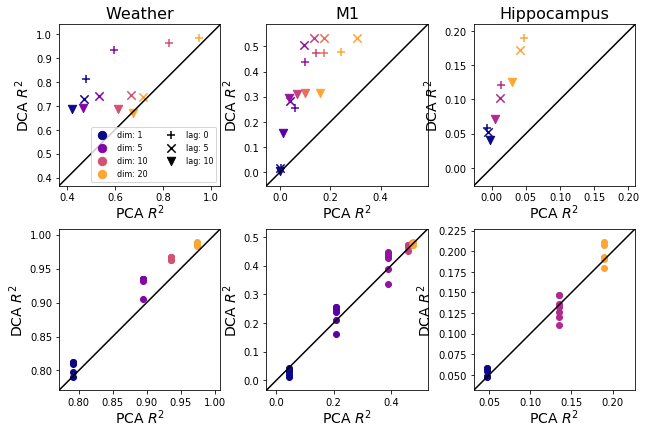

In [268]:
f = h5py.File(RESULTS_FILENAME, "r")

ax1, ax2, ax3, ax4, ax5, ax6 = decoding_fix_axes(fig_width=8, fig_height=4, wpad_edge=0, wpad_mid=0.08, hpad_edge=0, hpad_mid=0.15)
#plt.gcf().set_facecolor("red")

dsets = ["weather", "m1", "hc"]
print(dsets)
axes_top = (ax1, ax2, ax3)
axes_bottom = (ax4, ax5, ax6)

titles = {"hc": "Hippocampus", "m1": "M1", "weather": "Weather"}
for dset_idx in range(len(dsets)):
    ax = axes_top[dset_idx]
    dset = dsets[dset_idx]
    r2_vals = f[dset]["results"][:]
    dim_vals = f[dset].attrs["dim_vals"]
    offset_vals = f[dset].attrs["offset_vals"]
    num_cv_folds = f[dset].attrs["num_cv_folds"]
    T_pi_vals = f[dset].attrs["T_pi_vals"]
    legend = (dset_idx == 0)
    scatter_r2_vals(r2_vals, 5, dim_vals, offset_vals, ax=ax, legend=legend)
    ax.set_title(titles[dset], fontsize=16)
    plot_pi_vs_T(r2_vals, T_pi_vals, dim_vals, ax=axes_bottom[dset_idx])



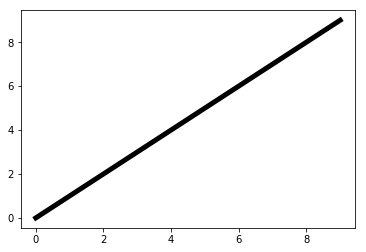

In [4]:
#TRY FORMING CACHE WITH 50 MS BINS!!!

In [48]:
dim_vals

array([ 1,  5, 10, 20, 30, 40])